## JRees Capstone Project: An Investigation of Topic Modeling Approaches for Historical FDA Court Case Texts  

<a href="#proposal">Part 1: Proposal</a>  
<a href="#EDA">Part 2: Exploratory Data Analysis and Data Preparation</a>  
<a href="#LSA">Part 3: Latent Semantic Analysis</a>  
<a href="#LDA">Part 4: Latent Dirichlet Allocation</a>  
<a href="#conclusion">Part 5: Conclusions</a>  

<a name="proposal">&nbsp;</a>
## Part 1: Proposal

This will be an unsupervised topic modeling problem. I will use Latent Semantic Analysis and Latent Dirichlet Allocation algorythms to create topic models from the the <a href="https://datadiscovery.nlm.nih.gov/dataset/FDA-Notices-of-Judgment-Collection-1908-1966-/cpdk-v8cd">FDA Notices of Judgment</a> Drugs and Devices data set available from NLM's Data Discovery application. These data consist of metadata and uncorrected OCR of the published summaries for Federal court cases prosecuting adulterated and misbranded drugs and devices by the FDA under the 1908 Pure Food and Drugs Act (ammended) between 1940-1963.  

**Goal: to surface additional topics and contexts not already identified by the Case Keywords or other metadata fields.**

There are 7,030 court case records in the data set with the following features:
   
   - **nj.collection**. Collection Identifier. We will use just the ddnj (drugs and devices) and fdnj (foods and drugs) sets.
   - **nj.identifier**. Seizure Case number
   - **nj.casekeywords**. Keyword terms
   - **nj.seizuredate**. Date(s) of the seizure(s)
   - **nj.adjudicatingcourtjurisdiction**. Federal Court where seizure case was tried
   - **nj.shippedfromcitystate**. Location from where the products were shipped
   - **nj.shippedintocitystate**. Location to where the products were shipped
   - **nj.seizurelocation**. Location where the FDA seized the products
   - **ocr.fulltext**. Full text OCR of the entire seizure case text
    
### DDNJ sample headers/rows (CSV)	
nj.identifier nj.caseissuedate nj.defendantnames nj.casekeywords nj.seizuredate nj.seizurelocation nj.shippedfromcitystate 	
nj.shippedintocitystate nj.adjudicatingcourtjurisdiction nj.njnumber nj.numbers nj.RightsStatement nj.RightsLink id nj.collection ocr.fulltext

ddnj00001  
May 1940  
B. C. Remedy Co.  
B. C. Headache Powders  
November 30, 1938  
Atlanta, Ga.  
Durham, N. C.  
Atlanta, Ga.  
Northern District of Georgia  
1  
F. D. C. No. 111. Sample No. 25097-D.  
The National Library of Medicine believes this item to be in the public domain
https://creativecommons.org/publicdomain/mark/1.0/  
ddnj00001  
ddnj
|1. Misbranding of B. C. Headache Powders, V. S. v. 46 Dozen Packages of|D. C. Default decree of condemnation and destruction. (F. D. C. No. 111.|Sample No. 25097-D.)|These powders consisted essentially of acetanilid, aspirin, caffeine, and|potassium bromide. They would be dangerous to health when used in the dosage|or with the frequency or duration prescribed, recommended, or suggested in|the labeling, which directed a dosage of one powder which might be repeated|once or twice at intervals of 3 or 4 hours if indicated. Its labeling failed to|reveal facts material with respect to the consequences which might result from|the use of the article under the conditions of use prescribed in the labeling|and failed to bear warnings against use in pathological conditions where its|use might be dangerous to health or against unsafe dosage or duration of|administration.|On or about January 4, 1939, the United States attorney for the Northern|District of Georgia filed a libel against 46 dozen packages of B. C. Headache|Powders at Atlanta, Ga.; alleging that the article had been shipped in inter-|state commerce on or about November 30, 1938, by B. C. Remedy Co. from|Durham, N. 0,; and charging that it was misbranded for the reasons appearing|above.|1 Notices of Judgment under the Federal Food, Drug, and Cosmetic Act are published|in three series: Foods (F. N. J.) ; Drugs and Devices (D. D. N. J.) ; and Cosmetics|(C. N. J.).|220127*-40 1 |IRECE i '?/ ED J?Hr MAY 2 81940 * ||it be permitted to withdraw its claim and answer, such petition having been|granted, and no answer or defense being before the court at that time, judgment|of condemnation was entered and the product was ordered destroyed.|  

<a name="EDA">&nbsp;</a>
## Part 2: Exploratory Data Analysis and Data Preparation

## Import packages  

We will be using standard pandas and numpy packages, plus othe natual language processing vectorization, modeling, and visualization packages such as Yellowbrick, spaCY, nltk, pyLDAvis, Wordcloud, and gensim.

In [1]:
import pandas as pd
import numpy as np

import re
import random
import warnings
warnings.simplefilter('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline


import yellowbrick
from yellowbrick.text import FreqDistVisualizer

import spacy
from spacy import displacy
from spacy.util import minibatch, compounding
from spacy.tokens import Doc

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')


import pyLDAvis.sklearn
from collections import Counter
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS


pd.options.mode.chained_assignment = None
pd.set_option('display.max_colwidth', 100)

from gensim import matutils, corpora
from gensim.models import Word2Vec
from gensim.corpora import MmCorpus, dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel

import pyLDAvis.gensim

import matplotlib.pyplot as plt
pd.options.display.float_format = '{:,.10f}'.format
plt.rcParams.update({'font.size': 32})
%matplotlib inline



[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\reesj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\reesj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\reesj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Program Files\Anaconda\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


## Load the drugs and devices data as a dataframe

In [2]:
path = './data/ddnj.csv'

ddnj = pd.read_csv(path)

In [3]:
warnings.simplefilter('ignore')

## Perform some basic inspections

In [4]:
ddnj.head()

,nj.title,nj.identifier,nj.caseissuedate,nj.defendantnames,nj.casekeywords,nj.seizuredate,nj.seizurelocation,nj.shippedfromcitystate,nj.shippedintocitystate,nj.adjudicatingcourtjurisdiction,nj.njnumber,nj.numbers,nj.RightsStatement,nj.RightsLink,id,nj.collection,ocr.fulltext
0,"1. Misbranding of B. C. Headache Powders, U. S. v. 46 Dozen Packages of B. C. Default decree of ...",ddnj00001,May 1940,B. C. Remedy Co.,B. C. Headache Powders,"November 30, 1938","Atlanta, Ga.","Durham, N. C.","Atlanta, Ga.",Northern District of Georgia,1,F. D. C. No. 111. Sample No. 25097-D.,The National Library of Medicine believes this item to be in the public domain,https://creativecommons.org/publicdomain/mark/1.0/,ddnj00001,ddnj,"|1. Misbranding of B. C. Headache Powders, V. S. v. 46 Dozen Packages of|D. C. Default decree of..."
1,2. Misbranding of Stanback Headache Powders. U. S. v. 309 Dozen Packages of Stanback Headache Po...,ddnj00002,May 1940,"Stanback Co. from Salisbury, N. C.",Stanback Headache Powders,"March 23, 1939","Atlanta, Ga.","Salisbury, N. C.","Atlanta, Ga.",Northern District of Georgia,2,"F. D. C. No. 207. Sample Nos. 44801-D, 44863-D.",The National Library of Medicine believes this item to be in the public domain,https://creativecommons.org/publicdomain/mark/1.0/,ddnj00002,ddnj,|2. Misbranding of Stanback Headache Powders. U. S. v. 309 Dozen Packages|of Stamback Headache P...
2,"3. Misbranding of Goody's Headache Powder. U. S. v. 1,524 Envelopes of Goody's Headache Powder. ...",ddnj00003,May 1940,"Goody's, Inc.",Goody's Headache Powder,"March 1, 1939","Columbia, S. C.","Winston-Salem, N. C.","Columbia, S. C.",Eastern District of South Carolina,3,F. D. C. No. 211. Sample No. 45525-D.,The National Library of Medicine believes this item to be in the public domain,https://creativecommons.org/publicdomain/mark/1.0/,ddnj00003,ddnj,"|3. Misbranding of Goody's Headache Powder. TJ. S. v. 1,524 Envelopes of|G..."
3,4. Misbranding of B-B Headache Powders. U. S. v. 596 Envelopes of B-B. Default decree of condemn...,ddnj00004,May 1940,Specialty Sales Co. from Atlanta Ga.,B-B Headache Powders,"June 6, 1939","Columbia, S. C.","Atlanta, Ga.","Columbia, S. C.",Eastern District of South Carolina,4,F. D. C. No. 215. Sample - No. 45524-D.,The National Library of Medicine believes this item to be in the public domain,https://creativecommons.org/publicdomain/mark/1.0/,ddnj00004,ddnj,|4. Misbranding of B-B Headache Powders. II. S. v. 596 Envelopes of B-B. (|Default d...
4,5. Misbranding of Hed-Lyte. U. S. v. 93 Bottles of Hed-Lyte. Default decree of condemnation and ...,ddnj00005,May 1940,Hed-Lyte Co.,Hed-Lyte,"March 6, 1939","Shreveport, La.","Dallas, Tex.","Shreveport, La.",Western District of Louisiana,5,F. D. C. No. 225. Sample No. 38055-D.,The National Library of Medicine believes this item to be in the public domain,https://creativecommons.org/publicdomain/mark/1.0/,ddnj00005,ddnj,|5. Misbranding of Hed-Lyte. U. S. v. 93 Bottles of Hed-Lyte. Default decree|of condemnat...


In [5]:
ddnj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7030 entries, 0 to 7029
Data columns (total 17 columns):
nj.title                            7030 non-null object
nj.identifier                       7030 non-null object
nj.caseissuedate                    7030 non-null object
nj.defendantnames                   7030 non-null object
nj.casekeywords                     7030 non-null object
nj.seizuredate                      7029 non-null object
nj.seizurelocation                  7030 non-null object
nj.shippedfromcitystate             7030 non-null object
nj.shippedintocitystate             7030 non-null object
nj.adjudicatingcourtjurisdiction    7030 non-null object
nj.njnumber                         7030 non-null object
nj.numbers                          7030 non-null object
nj.RightsStatement                  7030 non-null object
nj.RightsLink                       7030 non-null object
id                                  7030 non-null object
nj.collection                       70

## Seisuredate has one empty value we will need to handle

## Remove ```nj.``` from all the column names as this will cause problems calling the header names later on

In [5]:
#remove nj. from all the column names
ddnj.rename(columns={'nj.title':'title', 'nj.identifier':'identifier', 'nj.caseissuedate':'caseissuedate', 
                     'nj.defendantnames':'defendants', 'nj.casekeywords':'keywords', 'nj.seizuredate':'seizuredate',
                     'nj.seizurelocation':'seizurelocation', 'nj.shippedfromcitystate':'shippedfrom', 'nj.shippedintocitystate':'shippedinto',
                     'nj.njnumber':'njnumber', 'nj.numbers':'numbers', 'nj.RightsStatement':'rights', 'nj.RightsLink':'link',
                     'nj.adjudicatingcourtjurisdiction':'courtname', 
                     'nj.collection':'collection', 'ocr.fulltext':'ocr'}, inplace=True)


In [6]:
ddnj.head(1)

,title,identifier,caseissuedate,defendants,keywords,seizuredate,seizurelocation,shippedfrom,shippedinto,courtname,njnumber,numbers,rights,link,id,collection,ocr
0,"1. Misbranding of B. C. Headache Powders, U. S. v. 46 Dozen Packages of B. C. Default decree of ...",ddnj00001,May 1940,B. C. Remedy Co.,B. C. Headache Powders,"November 30, 1938","Atlanta, Ga.","Durham, N. C.","Atlanta, Ga.",Northern District of Georgia,1,F. D. C. No. 111. Sample No. 25097-D.,The National Library of Medicine believes this item to be in the public domain,https://creativecommons.org/publicdomain/mark/1.0/,ddnj00001,ddnj,"|1. Misbranding of B. C. Headache Powders, V. S. v. 46 Dozen Packages of|D. C. Default decree of..."


In [51]:
ddnj.describe()

,title,identifier,caseissuedate,defendants,keywords,seizuredate,seizurelocation,shippedfrom,shippedinto,courtname,njnumber,numbers,rights,link,id,collection,ocr
count,7030,7030,7030,7030,7030,7029,7030,7030,7030,7030,7030,7030,7030,7030,7030,7030,7030
unique,7030,7030,165,5838,5068,5994,1870,1765,2130,669,7030,7010,1,1,7030,1,7030
top,1880. Misbranding of Bonaid Tablets. U. S. v. 139 Bottles and 22 Bottles of Bonaid Tablets. Defa...,ddnj04117,June 1945,\N,prophylactics,\N,"Chicago, Ill.","New York, N. Y.","Chicago, Ill.",Northern District of Illinois,4494,\N,The National Library of Medicine believes this item to be in the public domain,https://creativecommons.org/publicdomain/mark/1.0/,ddnj04117,ddnj,"|4351. Adulteration of oxygen. U. S. v. John Suydam (Newburgh Oxygen Co.),|and George H. Gordon...."
freq,1,1,150,287,182,213,228,438,224,134,1,5,7030,7030,1,7030,1


**We also need to replace ```\N``` and ```|``` values**

## Perform some initial data cleanup:
- Impute undated for \N in date field
- Replace some widely occuring terms that will probably bias our topic modeling later, instead of adding them as stop words
- Replace pipes with a ```space```; have to escape them first

In [7]:
# replace \N newlines in seizuredate with 'undated'
ddnj.seizuredate.replace(r'\N', 'undated', inplace=True)

In [8]:
ddnj.isnull().sum()

title              0
identifier         0
caseissuedate      0
defendants         0
keywords           0
seizuredate        1
seizurelocation    0
shippedfrom        0
shippedinto        0
courtname          0
njnumber           0
numbers            0
rights             0
link               0
id                 0
collection         0
ocr                0
dtype: int64

## Still have one pesky NaN to replace

In [9]:
ddnj['seizuredate'].fillna('undated', inplace=True)

In [10]:
ddnj.isnull().sum()

title              0
identifier         0
caseissuedate      0
defendants         0
keywords           0
seizuredate        0
seizurelocation    0
shippedfrom        0
shippedinto        0
courtname          0
njnumber           0
numbers            0
rights             0
link               0
id                 0
collection         0
ocr                0
dtype: int64

In [11]:
# replace \N newlines everywhere else with nothing
ddnj.replace(r'\N', '', inplace=True)

In [12]:
ddnj.replace(r'Misbranding', '', regex=True, inplace=True)

In [13]:
ddnj.replace(r'Adulteration', '', regex=True, inplace=True)

In [14]:
ddnj.replace(r'misbranding', '', regex=True, inplace=True)

In [15]:
ddnj.replace(r'adulteration', '', regex=True, inplace=True)

In [16]:
ddnj.replace(r'Default decree of condemnation and destruction', '', regex=True, inplace=True)

In [17]:
ddnj.replace(r'\|', ' ', regex=True, inplace=True)

In [18]:
ddnj.head(1)

,title,identifier,caseissuedate,defendants,keywords,seizuredate,seizurelocation,shippedfrom,shippedinto,courtname,njnumber,numbers,rights,link,id,collection,ocr
0,"1. of B. C. Headache Powders, U. S. v. 46 Dozen Packages of B. C. .",ddnj00001,May 1940,B. C. Remedy Co.,B. C. Headache Powders,"November 30, 1938","Atlanta, Ga.","Durham, N. C.","Atlanta, Ga.",Northern District of Georgia,1,F. D. C. No. 111. Sample No. 25097-D.,The National Library of Medicine believes this item to be in the public domain,https://creativecommons.org/publicdomain/mark/1.0/,ddnj00001,ddnj,"1. of B. C. Headache Powders, V. S. v. 46 Dozen Packages of D. C. . (F. D. C. No. 111. Sample ..."


## Grab just the columns we want into another dataframe  

Using our domain knowledge, we can drop several columns which contain irrelevant topic modeling data, such as identifiers, some case index numbers, rights statements, url.

In [19]:
# grab just the columns we want into another df
ddnj_df = ddnj[['title', 'keywords', 'defendants', 'seizuredate', 'seizurelocation', 'courtname', 'ocr']]

ddnj_df.head(1)

,title,keywords,defendants,seizuredate,seizurelocation,courtname,ocr
0,"1. of B. C. Headache Powders, U. S. v. 46 Dozen Packages of B. C. .",B. C. Headache Powders,B. C. Remedy Co.,"November 30, 1938","Atlanta, Ga.",Northern District of Georgia,"1. of B. C. Headache Powders, V. S. v. 46 Dozen Packages of D. C. . (F. D. C. No. 111. Sample ..."


## Combine selected columns into a new column called ```combined``` to use as our documents for Natural Language Processing  

The theory is we can leverage the corrected text in the metadata fields along with the dirty OCR to increase our chances of generating useful topics.

In [20]:
# cast all the columns into a new one

ddnj_df['combined'] = ddnj_df['title'] + ddnj_df['keywords'] + ddnj_df['defendants'] + ddnj_df['seizuredate']+ ddnj_df['seizurelocation']+ ddnj_df['courtname']+ ddnj_df['ocr']

In [21]:
ddnj_df.head(1)

,title,keywords,defendants,seizuredate,seizurelocation,courtname,ocr,combined
0,"1. of B. C. Headache Powders, U. S. v. 46 Dozen Packages of B. C. .",B. C. Headache Powders,B. C. Remedy Co.,"November 30, 1938","Atlanta, Ga.",Northern District of Georgia,"1. of B. C. Headache Powders, V. S. v. 46 Dozen Packages of D. C. . (F. D. C. No. 111. Sample ...","1. of B. C. Headache Powders, U. S. v. 46 Dozen Packages of B. C. .B. C. Headache PowdersB. C. ..."


## EDA Visualizations

Let's create a function to generate a Wordcloud of the top 100 words; we can use this later, too.

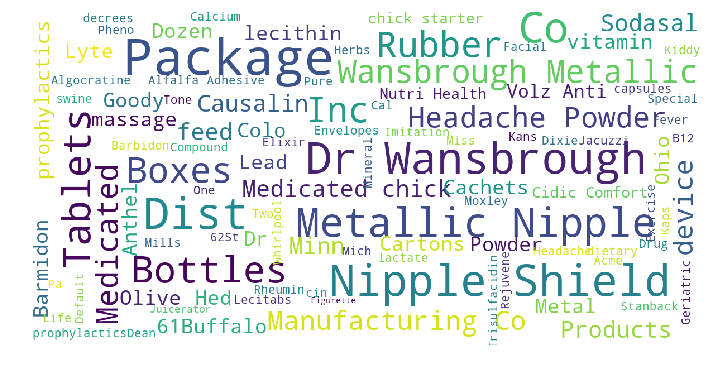

In [56]:
def show_wordcloud(text):
    """Take a set of text, apply Wordcloud and plot the results as a wordcloud visualization """
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stop_words,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    wordcloud=wordcloud.generate(str(text))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(ddnj_df['combined'])

**Let's use Yellowbrick's Frequency visualizer to better visualize the top 50 word tokens after vectorizing the words, and exludeg stop words, in our dataframe ```ddnj_df['combined']```, to see what other biased word we may want to handle.**

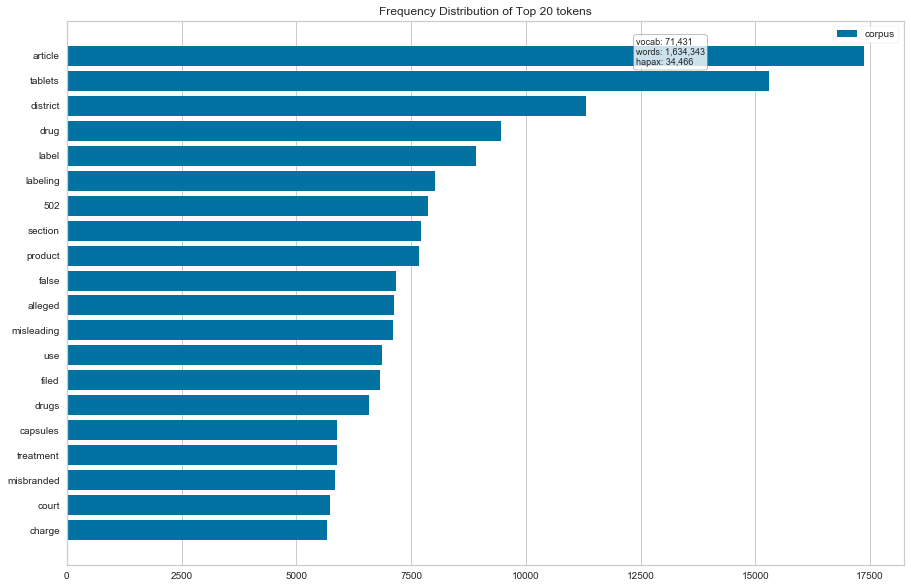

In [22]:
#font = {'size'   : 32}

#plt.rc('font', **font)


vectorizer = CountVectorizer(stop_words='english')
docs       = vectorizer.fit_transform(ddnj_df['combined'])
features   = vectorizer.get_feature_names()

visualizer = FreqDistVisualizer(n=20, features=features, size=(1080, 720)) #default N is 50, can change counts here
visualizer.fit(docs)

    
visualizer.show();

**It looks like there are some commonly occuring legal terms that we can exlude with some pre-processing, but we also need to be careful to not handle-away terms that might be actual topics for our models to discover. We canuse our domain knowledge again here.**

<a name="LSA"></a>
## Part 3: Latent Semantic Analysis  

The Latent Semantic Analysis model is a theory for how meaning representations might be learned from encountering large samples of language without explicit directions as to how it is structured.  

LSA inherently follows certain assumptions:  
1. Meaning of Sentences or Documents is a sum of the meaning of all words occurring in it. Overall, the meaning of a certain word is an average across all the documents it occurs in.  
2. LSA assumes that the semantic associations between words are present not explicitly, but only latently in the large sample of language.  

We will form a document-term matrix using the Term Frequency-Inverse Document Frequency (TF-IDF) transformation method to vectorize the corpus. There is a drawback in that TF-IDF prdouces a noisy and sparse matrix, sometimes too large to even compute for further processes. 

To reduce the noise we perform a Low-Rank Approximation using a Dimensionality reduction technique using a Truncated Singular Value Decomposition (SVD). Truncated SVD reduces dimensionality by selecting only the largest singular values.  

With these document vectors and term vectors, we can apply measures such as cosine similarity to evaluate:
- the similarity of different documents
- the similarity of different words
- the similarity of terms

In [23]:
# Workspace
drugs=pd.DataFrame(ddnj_df, columns=['combined'])

#remove special characters
drugs['clean_documents'] = drugs['combined'].str.replace("[^a-zA-Z#]", " ")

#remove words have letters less than 3
drugs['clean_documents'] = drugs['clean_documents'].fillna('').apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

#lowercase all characters
drugs['clean_documents'] = drugs['clean_documents'].fillna('').apply(lambda x: x.lower())

In [24]:
drugs.head()


,combined,clean_documents
0,"1. of B. C. Headache Powders, U. S. v. 46 Dozen Packages of B. C. .B. C. Headache PowdersB. C. ...",headache powders dozen packages headache powdersb remedy november atlanta northern district geor...
1,2. of Stanback Headache Powders. U. S. v. 309 Dozen Packages of Stanback Headache Powders. .Sta...,stanback headache powders dozen packages stanback headache powders stanback headache powdersstan...
2,"3. of Goody's Headache Powder. U. S. v. 1,524 Envelopes of Goody's Headache Powder. .Goody's He...",goody headache powder envelopes goody headache powder goody headache powdergoody inc march colum...
3,4. of B-B Headache Powders. U. S. v. 596 Envelopes of B-B. .B-B Headache PowdersSpecialty Sales...,headache powders envelopes headache powdersspecialty sales from atlanta june columbia eastern di...
4,"5. of Hed-Lyte. U. S. v. 93 Bottles of Hed-Lyte. .Hed-LyteHed-Lyte Co.March 6, 1939Shreveport, ...",hed lyte bottles hed lyte hed lytehed lyte march shreveport western district louisiana hed lyte ...


In [25]:
#Build the TF-IDF DTM
vectorizer = TfidfVectorizer(stop_words='english', 
                             use_idf=True, 
                             smooth_idf=True)

# SVD to reduce dimensionality; n_components defines the number of topics; change this to learn more: 
# could combine gridsearch to tell us how many to define n_components
svd_model = TruncatedSVD(n_components=3,         
                         algorithm='randomized',
                         n_iter=20)

# Using a pipeline for fun to combine tf-idf + SVD fitting against corpus
svd_transformer = Pipeline([('tfidf', vectorizer), 
                            ('svd', svd_model)])
svd_matrix = svd_transformer.fit_transform(drugs['clean_documents'])

In [26]:
# Let's capture the output of our topic model
topic_encoded_df = pd.DataFrame(svd_matrix, columns = ["topic_1", "topic_2", "topic_3"])
topic_encoded_df["documents"] = drugs['clean_documents']

## Let's sort each topic category score and see what are the top 5

**Topic 1**

In [27]:
# Using the below - what are some topics?
topic_encoded_df.sort_values(by=['topic_1'], ascending=False)[:5]

,topic_1,topic_2,topic_3,documents
6509,0.5279701017,0.2994838836,0.0339679279,achromycin capsules dextro amphetamine sulfate capsules dextro amphetamine sulfate tablets penic...
5951,0.5169902765,0.3548542786,0.0489076552,secobarbital sodium capsules dextro amphetamine sulfate tabletsisador kammer belt avenue pharmac...
3088,0.4831423666,0.2107882018,0.0019882144,amphetamine hydrochloride tablets david avila west side drug store plea guilty fine plus costs a...
6829,0.4801626445,0.1946005056,0.0049769508,thorazine tabletsjohn berntsen john berntsen pharmacy and hugh leonard pharmacist provo utah pro...
5673,0.4744469398,0.0097656874,-0.1092965137,vitamin capsules vitamin capsules philadelphia dist department health education and welfare food...


**Topic 2**

In [28]:
# Using the below - what are some topics?
topic_encoded_df.sort_values(by=['topic_2'], ascending=False)[:5]

,topic_1,topic_2,topic_3,documents
5672,0.3445614892,0.4408951252,0.1136463693,equanil tablets meticorten tablets gantrisin tablets penicillin tabletsseymour sanov macgregor p...
4516,0.3252399800,0.4347864718,0.1025510355,seconal sodium capsulesray wiener hillcrest pharmacy portland oreg between and oreg dist oreg no...
5832,0.3130672496,0.4289401947,0.1038056965,tablets containing mixture carbromal and pentobarbital sodium chloromycetin capsules aristocort ...
5532,0.3129977636,0.4278848930,0.1065018381,dexedrine spansule capsules gantrisin tabletsharry margolis margolis pharmacy brooklyn brooklyn ...
6388,0.2911733309,0.3982274335,0.1214884082,miltoton tabletsalexander lobel alexander lobel pharmacy jamaica and jamaica dist nos informatio...


**Topic 3**

In [29]:
# Using the below - what are some topics?
topic_encoded_df.sort_values(by=['topic_3'], ascending=False)[:5]

,topic_1,topic_2,topic_3,documents
1812,0.2362464631,-0.3519523623,0.6322149033,and prophylactics gross and gross prophylactics default decree destruction prophylacticsm jacobs...
1913,0.2503624699,-0.3664723432,0.6279870308,and prophylactics gross prophylactics prophylacticsgoodwear rubber from new york march baltimore...
2851,0.3047185135,-0.3548415895,0.6168794504,and prophylactics gross prophylacticsgoodwear rubber from new york may louis eastern district mi...
5628,0.2255786406,-0.3095184162,0.6141234497,rubber prophylactics rubber prophylacticsakwell corp new york dist rubber prophylactics nos quan...
1763,0.2942658648,-0.3738674052,0.6007396351,and prophylactics gross prophylactics and other seizure actions against prophylactics default de...


What are some likely topics applying my domain knowledge of the original data set?
- **Topic 1 with cosines in the 0.50 range = amphetamine tablets/capsules**
- **Topic 2 with cosines in the 0.42 range = penicillin, tablets, capsules, pharmacy, amphetamines and barbituates (uppers and downers)**
- **Topic 3 with cosines in the 0.61 range = prophylactics, default decrees of condemnation**

Using our domain knowledge we already know amphetamines, barbituates, and prophylatics are abundant based on the Case Keywords metadata. **Penicillin is something new.**  

Let's try LDA to see if we get any more satisfying results.

<a name="LDA"></a>
## Part 4: Latent Dirichlet Allocation  

LDA is used to classify text in a document to a particular topic. It is generally considered more robust than LSA in that it is baed on probalistic distributions rather than K-Means averages. It builds a topic per document model and words per topic model, modeled as distributions. Each document is modeled as a distribution of topics and each topic is modeled as a distribution of words. LDA assumes that every chunk of text will contain words that are somehow related. It also assumes documents are produced from a mixture of topics. Those topics then generate words based on their probability distribution. Topic probabilities provide an explicit representation of a document.

In [30]:
drugs_lda = pd.DataFrame(ddnj_df, columns=['combined'])


In [31]:
drugs_lda.head()

,combined
0,"1. of B. C. Headache Powders, U. S. v. 46 Dozen Packages of B. C. .B. C. Headache PowdersB. C. ..."
1,2. of Stanback Headache Powders. U. S. v. 309 Dozen Packages of Stanback Headache Powders. .Sta...
2,"3. of Goody's Headache Powder. U. S. v. 1,524 Envelopes of Goody's Headache Powder. .Goody's He..."
3,4. of B-B Headache Powders. U. S. v. 596 Envelopes of B-B. .B-B Headache PowdersSpecialty Sales...
4,"5. of Hed-Lyte. U. S. v. 93 Bottles of Hed-Lyte. .Hed-LyteHed-Lyte Co.March 6, 1939Shreveport, ..."


In [32]:
# Remove punctuation
drugs_lda['abstract_processed'] = drugs_lda['combined'].map(lambda x: re.sub(r'[^\w\s]', '', x))

# Convert the titles to lowercase
drugs_lda['abstract_processed'] = drugs_lda['abstract_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
drugs_lda['abstract_processed'][0:4]


0    1  of b c headache powders u s v 46 dozen packages of b c b c headache powdersb c remedy conovem...
1    2  of stanback headache powders u s v 309 dozen packages of stanback headache powders stanback h...
2    3  of goodys headache powder u s v 1524 envelopes of goodys headache powder goodys headache powd...
3    4  of bb headache powders u s v 596 envelopes of bb bb headache powdersspecialty sales co from a...
Name: abstract_processed, dtype: object

In [33]:
#Lemmatize the data to reduce the feature space

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
drugs_lda['abstract_lemma'] = drugs_lda['abstract_processed'].map(lambda x: [token.lemma_ for token in nlp(x) if token.lemma_ != '-PRON-' and token.pos_ in {'NOUN', 'VERB', 'ADJ', 'ADV'}])

# Final cleaning, dropping 1 letter words
drugs_lda['abstract_processed_lemma'] = drugs_lda['abstract_lemma'].map(lambda x: [t for t in x if len(t) > 1])

# Example
print(drugs_lda['abstract_processed_lemma'].iloc[0][:25], end='\n\n')

['headache', 'powder', 'dozen', 'package', 'remedy', 'conovember', 'ganorthern', 'district', 'headache', 'powder', 'dozen', 'package', 'sample', '25097d', 'powder', 'consist', 'essentially', 'acetanilid', 'caffeine', 'potassium', 'bromide', 'dangerous', 'health', 'when', 'use']



Lemmatizing the raw OCR removes a lot of the regularly occuring legaleese phrases, but I still see some regularly occuring words that could bias our topic generation results  

Lets updated the NLTK English stopwords list

In [34]:
stop_words = set(stopwords.words('english'))

#add words that aren't in the NLTK stopwords list
new_stopwords = ['condemnation', 'destruction', 'default', 'decree', 'article', 
                 'sample', 'contain', 'defendant', 'labeling', 'product', 'allege'
                'court', 'false', 'statement']
new_stopwords_list = stop_words.union(new_stopwords)

In [35]:
# Let's remove stopwords and see the difference
stop_en = new_stopwords_list
drugs_lda['abstract_processed_lemma'] = drugs_lda['abstract_processed_lemma'].map(lambda x: [t for t in x if t not in stop_en]) 
print(drugs_lda['abstract_processed_lemma'].iloc[0][:25])

['headache', 'powder', 'dozen', 'package', 'remedy', 'conovember', 'ganorthern', 'district', 'headache', 'powder', 'dozen', 'package', '25097d', 'powder', 'consist', 'essentially', 'acetanilid', 'caffeine', 'potassium', 'bromide', 'dangerous', 'health', 'use', 'dosage', 'frequency']


In [36]:
drugs_lda['abstract_processed_lemma'].head()

0    [headache, powder, dozen, package, remedy, conovember, ganorthern, district, headache, powder, d...
1    [stanback, powder, dozen, package, stanback, powder, stanback, co, cmarch, ganorthern, district,...
2    [envelope, ceastern, district, destruc, tion, 45525d, powder, potassium, bromide, caffeine, dang...
3    [powder, envelope, powdersspecialty, sale, co, ceastern, district, envelope, 45524d, powder, pot...
4    [bottle, lawestern, district, bottle, hedlyte, 38055d, drug, acetanilid, sodium, bromide, caffei...
Name: abstract_processed_lemma, dtype: object

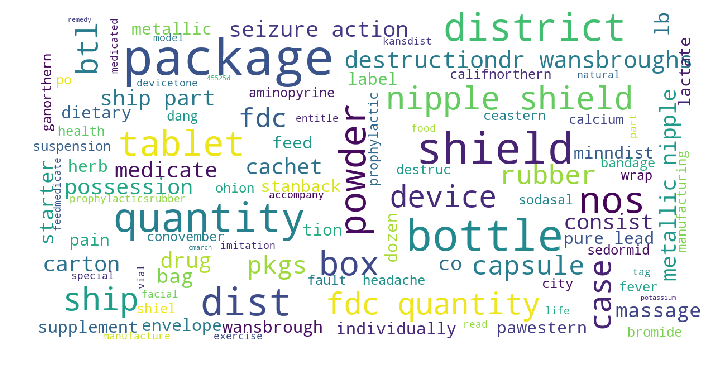

In [45]:
show_wordcloud(drugs_lda['abstract_processed_lemma'])

## Sanity check that our dataframe is as we expect with the addition of 3 new columns *_processed*; *_ lemma*; and *_processed__lemma*

In [37]:
drugs_lda.head()

,combined,abstract_processed,abstract_lemma,abstract_processed_lemma
0,"1. of B. C. Headache Powders, U. S. v. 46 Dozen Packages of B. C. .B. C. Headache PowdersB. C. ...",1 of b c headache powders u s v 46 dozen packages of b c b c headache powdersb c remedy conovem...,"[headache, powder, v, dozen, package, b, c, b, remedy, conovember, ganorthern, district, headach...","[headache, powder, dozen, package, remedy, conovember, ganorthern, district, headache, powder, d..."
1,2. of Stanback Headache Powders. U. S. v. 309 Dozen Packages of Stanback Headache Powders. .Sta...,2 of stanback headache powders u s v 309 dozen packages of stanback headache powders stanback h...,"[stanback, powder, v, dozen, package, stanback, powder, stanback, co, cmarch, ganorthern, distri...","[stanback, powder, dozen, package, stanback, powder, stanback, co, cmarch, ganorthern, district,..."
2,"3. of Goody's Headache Powder. U. S. v. 1,524 Envelopes of Goody's Headache Powder. .Goody's He...",3 of goodys headache powder u s v 1524 envelopes of goodys headache powder goodys headache powd...,"[v, envelope, ceastern, district, default, decree, condemnation, destruc, tion, d, c, sample, 45...","[envelope, ceastern, district, destruc, tion, 45525d, powder, potassium, bromide, caffeine, dang..."
3,4. of B-B Headache Powders. U. S. v. 596 Envelopes of B-B. .B-B Headache PowdersSpecialty Sales...,4 of bb headache powders u s v 596 envelopes of bb bb headache powdersspecialty sales co from a...,"[powder, v, envelope, powdersspecialty, sale, co, ceastern, district, v, envelope, c, sample, 45...","[powder, envelope, powdersspecialty, sale, co, ceastern, district, envelope, 45524d, powder, pot..."
4,"5. of Hed-Lyte. U. S. v. 93 Bottles of Hed-Lyte. .Hed-LyteHed-Lyte Co.March 6, 1939Shreveport, ...",5 of hedlyte u s v 93 bottles of hedlyte hedlytehedlyte comarch 6 1939shreveport lawestern dist...,"[v, bottle, lawestern, district, s, v, bottle, hedlyte, default, decree, condemnation, destructi...","[bottle, lawestern, district, bottle, hedlyte, 38055d, drug, acetanilid, sodium, bromide, caffei..."


In [38]:
# Create a corpus from a list of the texts
texts = drugs_lda.sample(n=500, random_state=43)['abstract_processed_lemma'].values
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

Build the LDA model

In [39]:
n_topics=9

my_lda = LdaModel(corpus, num_topics=n_topics, id2word=dictionary, random_state=42, minimum_probability=0)

In [40]:
# We can limit what is returned by specifying the number of topics we're interested in and the number of works to return
num_topics = 9
num_words = 5
for ti, topic in enumerate(my_lda.show_topics(num_topics = num_topics, num_words= num_words)):
    print("Topic: %d" % (ti))
    print (topic)
    print()

Topic: 0
(0, '0.012*"label" + 0.011*"section" + 0.009*"drug" + 0.009*"use" + 0.009*"tablet"')

Topic: 1
(1, '0.007*"food" + 0.007*"use" + 0.006*"label" + 0.006*"vitamin" + 0.006*"court"')

Topic: 2
(2, '0.007*"allege" + 0.006*"label" + 0.005*"misleading" + 0.005*"drug" + 0.005*"use"')

Topic: 3
(3, '0.008*"use" + 0.008*"vitamin" + 0.006*"drug" + 0.006*"capsule" + 0.006*"allege"')

Topic: 4
(4, '0.014*"drug" + 0.010*"label" + 0.009*"bottle" + 0.009*"use" + 0.009*"section"')

Topic: 5
(5, '0.021*"tablet" + 0.012*"drug" + 0.011*"use" + 0.009*"section" + 0.009*"label"')

Topic: 6
(6, '0.012*"tablet" + 0.007*"device" + 0.006*"label" + 0.006*"bottle" + 0.006*"court"')

Topic: 7
(7, '0.014*"tablet" + 0.009*"drug" + 0.009*"vitamin" + 0.007*"treatment" + 0.007*"ship"')

Topic: 8
(8, '0.017*"tablet" + 0.015*"drug" + 0.010*"capsule" + 0.010*"sulfate" + 0.008*"charge"')



In [41]:
# How similar are topics? Remember cosine similarity from above. It's built-in to gensim letting us see how similar topics are to each other
# how similar are topic 0 and 1 62%
matutils.cossim(my_lda.get_topic_terms(0), my_lda.get_topic_terms(1))

0.5475896541981794

## Analyzing LDA model results  

How similar are the topic words to each other, percentage-wise? Let's use Topic Coherence to measure the degree of semantic similarity between high scoring words in our first two topics 0 and 1.

In [51]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=my_lda, texts=drugs_lda['abstract_processed_lemma'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4588208681451842


Coherence score is just ok assuming that C__v coherence scores can be interpreted to mean:
- .3 is bad

- .4 is low

- .55 is okay

- .65 might be as good as it is going to get

- .7 is nice

- .8 is unlikely and

- .9 is probably wrong

Can we get a better Coherence score? We can generate a list of 30 max topics and plot the average and standard deviations for all of them to see if there is a sweet spot better than the score we get from first two topics.

In [52]:
max_topics = 30
coh_list = []
for n_topics in range(3,max_topics+1):
    # Train the model on the corpus
    my_lda = LdaModel(corpus, num_topics=n_topics, id2word=dictionary, random_state=42, alpha=0.1)
    # Estimate coherence
    cm = CoherenceModel(model=my_lda, texts=texts, dictionary=dictionary, coherence='c_v', topn=20)
    coherence = cm.get_coherence_per_topic() # get coherence value
    coh_list.append(coherence)

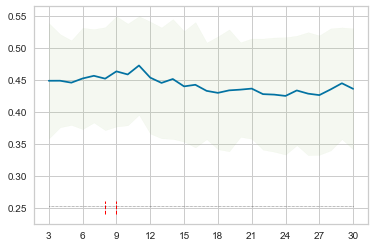

In [53]:
# Coherence scores:
coh_means = np.array([np.mean(l) for l in coh_list])
coh_stds = np.array([np.std(l) for l in coh_list])

#import matplotlib.pyplot as plt
#%matplotlib inline
plt.xticks(np.arange(3, max_topics+1, 3.0));
plt.plot(range(3,max_topics+1), coh_means);
plt.fill_between(range(3,max_topics+1), coh_means-coh_stds, coh_means+coh_stds, color='g', alpha=0.1);
plt.vlines([8, 9], 0.24, 0.26, color='red', linestyles='dashed',  linewidth=1);
plt.hlines([0.253], 3, max_topics, color='black', linestyles='dotted',  linewidth=0.5);

**It looks like we can bump the C_V to ~0.48 using 11 topics**

In [108]:
n_topics=11

my_lda = LdaModel(corpus, num_topics=n_topics, id2word=dictionary, random_state=42, minimum_probability=0)

In [109]:
# We can limit what is returned by specifying the number of topics we're interested in and the number of works to return
num_topics = 11
num_words = 5
for ti, topic in enumerate(my_lda.show_topics(num_topics = num_topics, num_words= num_words)):
    print("Topic: %d" % (ti))
    print (topic)
    print()

Topic: 0
(0, '0.013*"section" + 0.012*"label" + 0.012*"tablet" + 0.010*"drug" + 0.009*"use"')

Topic: 1
(1, '0.011*"vitamin" + 0.008*"use" + 0.007*"allege" + 0.007*"food" + 0.007*"drug"')

Topic: 2
(2, '0.018*"vitamin" + 0.012*"capsule" + 0.010*"tablet" + 0.010*"count" + 0.010*"drug"')

Topic: 3
(3, '0.010*"drug" + 0.009*"tablet" + 0.009*"label" + 0.009*"charge" + 0.009*"file"')

Topic: 4
(4, '0.014*"drug" + 0.012*"device" + 0.009*"use" + 0.009*"court" + 0.007*"misleading"')

Topic: 5
(5, '0.008*"device" + 0.008*"allege" + 0.007*"charge" + 0.007*"drug" + 0.007*"treatment"')

Topic: 6
(6, '0.020*"tablet" + 0.016*"drug" + 0.011*"capsule" + 0.009*"use" + 0.007*"label"')

Topic: 7
(7, '0.010*"use" + 0.009*"ship" + 0.008*"charge" + 0.007*"label" + 0.007*"allege"')

Topic: 8
(8, '0.030*"tablet" + 0.011*"drug" + 0.010*"label" + 0.008*"ship" + 0.008*"allege"')

Topic: 9
(9, '0.010*"drug" + 0.007*"ship" + 0.007*"capsule" + 0.006*"charge" + 0.006*"libel"')

Topic: 10
(10, '0.008*"bottle" + 0.008

In [110]:
# How similar are topics? Remember cosine similarity from above. It's built-in to gensim letting us see how similar topics are to each other
# how similar are topic 0 and 1 62%
matutils.cossim(my_lda.get_topic_terms(0), my_lda.get_topic_terms(1))

0.4582808123292886

In [111]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=my_lda, texts=drugs_lda['abstract_processed_lemma'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4771637646427463


## Using our domain knowledge, what topics do I see emerge?

- Cases about tablet labelling (twice)
- Drug tablet court cases. Yes, we know that already
- Vitamin tablet labeling. Somewhat interesting; didn't realize vitamins were so prevalent; I expected ```amphetamine``` to be more prevalent
- Drug and device labeling. Yes, we know this already; the data set is defined as ```drugs and devices```

**Our co-similarity percentage for the first two topics increased slightly, but C_V did not increase meaningfully nor get to the estimated 0.48 range. We could engineer to add even more stopwords, but may likely never reach the end knowing that the writing style for this set of FDANJ cases is very stylized with lots of legaleese, so let's move forward with some interesting visualization demonstration.**

## Visualization  

Using pyLDAvis, let's see how the topics rank based on **relevance** rather than **coherence**. Hopefully a visualization will surface the topics more easily.

pyLDAvis gives us:
- a left panel that depicts a global view of the model (how prevalent each topic is and how topics relate to each other);
- a right panel containing a bar chart – the bars represent the terms that are most useful in interpreting the topic currently selected (what the meaning of each topic is).

On the left, the topics are plotted as circles whose centers are defined by the computed distance between topics. The circle's area indicates the prevalence of each topic. On the right, two juxtaposed bars display the topic-specific frequency of each term (in red) and the corpus-wide frequency (in blueish gray). When no topic is selected, the right panel displays the top 30 most relevant terms for the dataset.

## LDA Topic Model with 6 topics

In [42]:
# Reloading our model with 6 topics
n_topics=6
n_top_words = 30
my_lda = LdaModel(corpus, num_topics=n_topics, id2word=dictionary, random_state=42, minimum_probability=0)

**Using pyLDAvis let's visualize our topics in our feature space to see how divergent they were.**


&nbsp;

## Latent Dirichlet Allocation Visualization

In [43]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(my_lda, corpus, dictionary)

PreparedData(topic_coordinates=                  x             y  topics  cluster          Freq
topic                                                           
4     -0.0104648931  0.0035290345       1        1 29.1930770874
5     -0.0330883748 -0.0087483451       2        1 21.5923748016
1      0.0261589698 -0.0180971954       3        1 20.5979785919
0     -0.0134510388  0.0030366622       4        1 15.4444437027
3      0.0169351482 -0.0067385236       5        1  7.8812608719
2      0.0139101888  0.0270183674       6        1  5.2908682823, topic_info=     Category           Freq          Term          Total       loglift  \
133   Default 917.0000000000        tablet 917.0000000000 30.0000000000   
21    Default 405.0000000000       capsule 405.0000000000 29.0000000000   
141   Default 399.0000000000       vitamin 399.0000000000 28.0000000000   
84    Default 445.0000000000    misleading 445.0000000000 27.0000000000   
146   Default 513.0000000000        allege 513.0000000000 26.0000000000   
311   Default  85.0000000000          hair  85.0000000000 25.0000000000   
195   Default 367.0000000000          food 367.0000000000 24.0000000000   
72    Default 617.0000000000         label 617.0000000000 23.0000000000   
301   Default 284.0000000000     condition 284.0000000000 22.0000000000   
39    Default 258.0000000000       disease 258.0000000000 21.0000000000   
266   Default 201.0000000000          show 201.0000000000 20.0000000000   
691   Default  90.0000000000  prophylactic  90.0000000000 19.0000000000   
239   Default 245.0000000000      claimant 245.0000000000 18.0000000000   
265   Default 315.0000000000     represent 315.0000000000 17.0000000000   
423   Default 149.0000000000      dispense 149.0000000000 16.0000000000   
171   Default 612.0000000000           use 612.0000000000 15.0000000000   
20    Default 159.0000000000        cancer 159.0000000000 14.0000000000   
192   Default 264.0000000000         enter 264.0000000000 13.0000000000   
521   Default 267.0000000000        sodium 267.0000000000 12.0000000000   
26    Default 505.0000000000        charge 505.0000000000 11.0000000000   
151   Default 330.0000000000        device 330.0000000000 10.0000000000   
86    Default 239.0000000000          name 239.0000000000  9.0000000000   
587   Default 219.0000000000          make 219.0000000000  8.0000000000   
42    Default 255.0000000000          dist 255.0000000000  7.0000000000   
119   Default 248.0000000000        result 248.0000000000  6.0000000000   
47    Default 810.0000000000          drug 810.0000000000  5.0000000000   
207   Default 339.0000000000     misbrande 339.0000000000  4.0000000000   
1285  Default  74.0000000000      solution  74.0000000000  3.0000000000   
41    Default 321.0000000000   disposition 321.0000000000  2.0000000000   
172   Default 152.0000000000         water 152.0000000000  1.0000000000   
...       ...            ...           ...            ...           ...   
146    Topic6  25.9237499237        allege 513.7564086914 -0.0474000014   
84     Topic6  23.3925018311    misleading 445.6651611328 -0.0080000004   
86     Topic6  15.6325139999          name 239.4405670166  0.2101999968   
20     Topic6  12.1651735306        cancer 159.4042510986  0.3662999868   
245    Topic6  10.8464756012       destroy 131.2206878662  0.4460999966   
359    Topic6  11.8545675278    government 153.9376525879  0.3754000068   
42     Topic6  15.7316331863          dist 255.9747772217  0.1498000026   
72     Topic6  25.0556335449         label 617.1760253906 -0.2648999989   
280    Topic6   9.1075363159          fall 100.1729354858  0.5414000154   
26     Topic6  21.9608287811        charge 505.3367309570 -0.1967999935   
170    Topic6   9.7204179764      standard 113.6634979248  0.4801999927   
21     Topic6  19.2569866180       capsule 405.5892028809 -0.1083000004   
258    Topic6  16.9740085602         order 327.0326538086 -0.0192000009   
236    Topic6  12.4583578110        appear 182.5105590820  0.2

We can see that topics 1, 2 and 3 and are similar in nature. The area of their circles are similar in size meaning they contain a similar number of salient terms. Their topic relavance are imprecise in that they are not prximate to each other or close to the center. Topics 1 and 4 however cluster close to the center and intersect each other, with 4 actually completely overlaying 1 meaning they are almost the same topic but with slightly different word saliency.  

What happened to amphetamines and prophylatics from our domain knowledge and the LSA modeling? Here's where pyLDAvis can help. If we lower the relevance metric to 0.4, topic 4 surfaces ```prophylactic``` as a top-30 term, but is still has a low occurence percentage. Similarly, topic 2 surfaces ```dexedrine```, which is an amphetamine, as top-30 term, but again as a low-percentage occurence. And we lost the actual word ```amphetamine```.


<a name="conclusion"></a>
## Part 5: Conclusions

LSA and LDA topic modeling algorythms confirmed what I as a domain expert already knew about the ddnj data set in that it is written in highly-stylized langauge.  

Those words and topics surfaced especially strongly using LDA, which we could probably have predicted as a null hypothesis since LDA uses a more statistically robust term scoring methodology. We learned that the texts produce lots of topics centered around drug tablets and capsules.  

LSA confirmed that **amphetamines, barbituates, and prophylatics** are highly-occuring word count averages which we know are also frequently occuring Case Keyword metadata terms. **LSA performed better than LDA in this regard.**  

One could extrapolate from the LSA and LDA models that there are lots of texts (court cases) involving the **interstate trade of misbranded or adulterated uppers and downers in capsule and table form between 1940 and 1963.**  

**Vitamins** as a topic was surfaced as new knowledge.  

I anticipate re-using this notebook for **future work** to explore other FDANJ subsets where the writing is less stylized and perhaps narrowing the feature space to produce more refined results and explore other topics such as geographic locations.